In [ ]:
!pip install -U albumentations>=0.3.0 --user 
!pip install -U --pre segmentation-models --user
!pip install segmentation-models==1.0.*
!pip install tensorflow==2.1.0
!pip install keras==2.3.1
!pip install 'h5py<3.0.0'

%matplotlib inline

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# image_names = glob.glob("/content/drive/MyDrive/BKAI-Challenge/data/image/*.png")
# image_names.sort()

In [ ]:
# mask_names = glob.glob("/content/drive/MyDrive/BKAI-Challenge/data/mask/*.png")
# mask_names.sort()

In [ ]:
# images = [cv2.imread(image, 1) for image in image_names] 
# image_dataset = np.array(images)

In [ ]:
# masks = [cv2.imread(mask, 0) for mask in mask_names]
# mask_dataset = np.array(masks)

In [ ]:
# import random
# img_number = random.randint(0, len(image_dataset)-1)
# img = image_dataset[img_number]
# mask = mask_dataset[img_number]
# plt.figure(figsize=(12, 8))
# plt.subplot(221)
# plt.title('Image')
# plt.imshow(img)
# plt.subplot(222)
# plt.title('Mask')
# plt.imshow(mask, cmap='gray')
# plt.show()

In [ ]:
# #Use customary x_train and y_train variables
# X = image_dataset
# Y = mask_dataset
# Y = np.expand_dims(Y, axis=3) #May not be necessary.. leftover from previous code 


# from sklearn.model_selection import train_test_split
# x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# # preprocess input
# x_train = preprocess_input(x_train)
# x_val = preprocess_input(x_val)

In [ ]:
DATA_DIR = '/content/drive/MyDrive/BK.AI Challenge/dataset/'

x_train_dir = os.path.join(DATA_DIR, 'train/image')
y_train_dir = os.path.join(DATA_DIR, 'train/mask')

x_valid_dir = os.path.join(DATA_DIR, 'validation/image')
y_valid_dir = os.path.join(DATA_DIR, 'validation/mask')

x_test_dir = os.path.join(DATA_DIR, 'test/image')
y_test_dir = os.path.join(DATA_DIR, 'test/mask')

## Utility functions

In [ ]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    """
    
    CLASSES = ['people']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

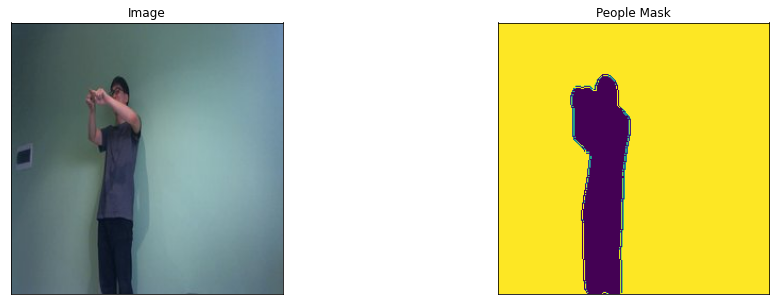

In [ ]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['people'])

image, mask = dataset[5]
visualize(
    image=image, 
    people_mask=mask[..., 0].squeeze(),
)

## Augmentations

In [ ]:
import albumentations as A

In [ ]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
        A.RandomCrop(height=256, width=256, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(256, 256)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/root/.local/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/root/.local/lib/python3.7/site-package

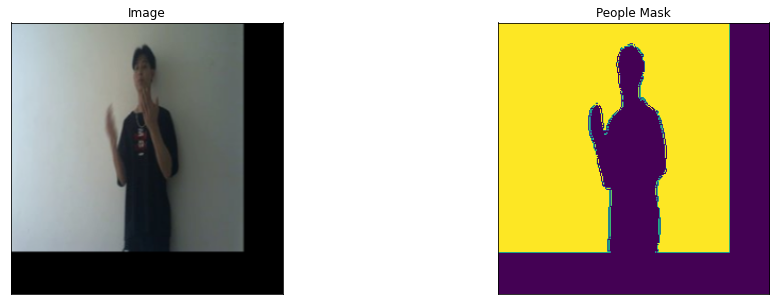

In [ ]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['people'], augmentation=get_training_augmentation())

image, mask = dataset[12] # get some sample
visualize(
    image=image, 
    people_mask=mask[..., 0].squeeze(),
)

## Segmentation model training

In [ ]:
import segmentation_models as sm

In [ ]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
CLASSES = ['people']
LR = 0.0001
EPOCHS = 10

preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./weight-model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/root/.local/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/root/.local/lib/python3.7/site-package

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/10
251/251 [==============================] - 180s 715ms/step - loss: 0.0353 - iou_score: 0.8883 - f1-score: 0.9337 - val_loss: -0.0701 - val_iou_score: 0.9712 - val_f1-score: 0.9849
Epoch 2/10
251/251 [==============================] - 139s 554ms/step - loss: -0.0864 - iou_score: 0.9632 - f1-score: 0.9812 - val_loss: -0.1197 - val_iou_score: 0.9801 - val_f1-score: 0.9897
Epoch 3/10
251/251 [==============================] - 139s 554ms/step - loss: -0.1127 - iou_score: 0.9699 - f1-score: 0.9847 - val_loss: -0.1324 - val_iou_score: 0.9842 - val_f1-score: 0.9920
Epoch 4/10
251/251 [==============================] - 139s 552ms/step - loss: -0.1218 - iou_score: 0.9710 - f1-score: 0.9853 - val_loss: -0.1367 - val_iou_score: 0.9863 - val_f1-score: 0.9931
Epoch 5/10
251/251 [==============================] - 139s 552ms/step - loss: -0.1291 - iou_score: 0.9734 - f1-score: 0.9865 - val_loss: -0.1404 - val_iou_score: 0.9875 - val_f1-score: 0.9937
Epoch 6/10
251/251 [=====================

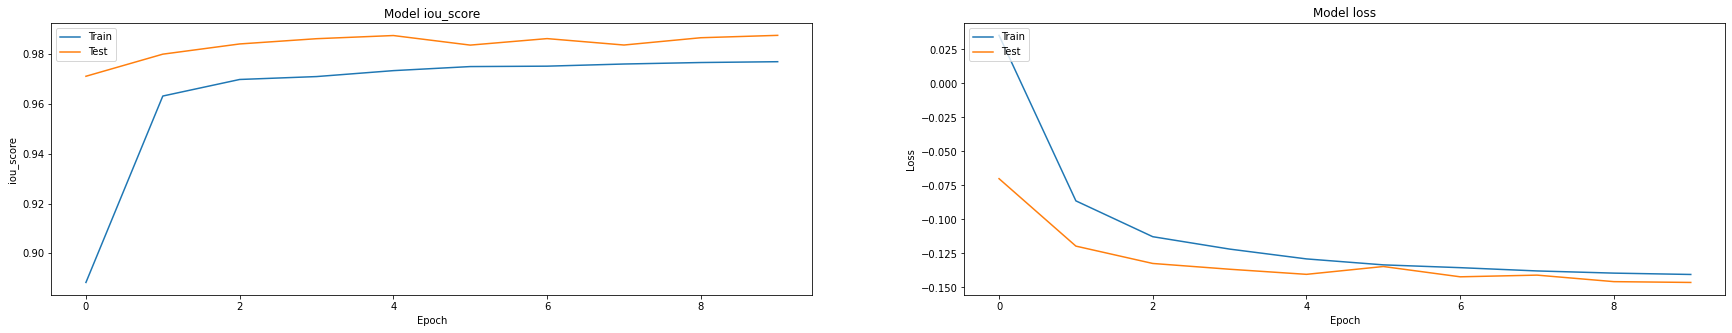

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Model Evaluation

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# load best weights
model.load_weights('best_model.h5') 

In [ ]:
model.save('/content/drive/MyDrive/BK.AI Challenge/weight-model.h5')

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 4.3719
mean iou_score: 1.8015e-10
mean f1-score: 1.8015e-10


In [ ]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        image=denormalize(image.squeeze()),
        pr_mask=pr_mask.squeeze(),
    )

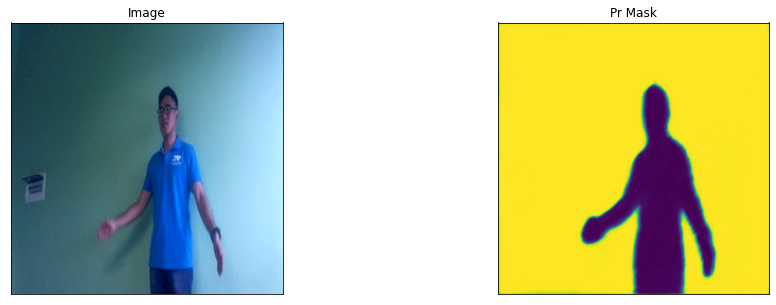

In [ ]:
image, gt_mask = test_dataset[2]
image = np.expand_dims(image, axis=0)
pr_mask = model.predict(image)

visualize(
    image=denormalize(image.squeeze()),
    pr_mask=pr_mask.squeeze())

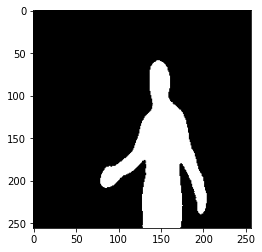

In [ ]:
a = np.array(pr_mask)
a = np.reshape(a, (256,256))
a = np.where(a < 0.5, 1, 0)
# numpy.reshape(input_in_4D, (1800,30))
plt.imshow(a, cmap='gray')

In [ ]:
pred_mask = []
for i in range(len(test_dataset)):
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    arr_mask = np.array(pr_mask)
    arr_mask = np.reshape(arr_mask, (256,256))
    arr_mask = np.where(arr_mask < 0.3, 1, 0)
    pred_mask.append(arr_mask)

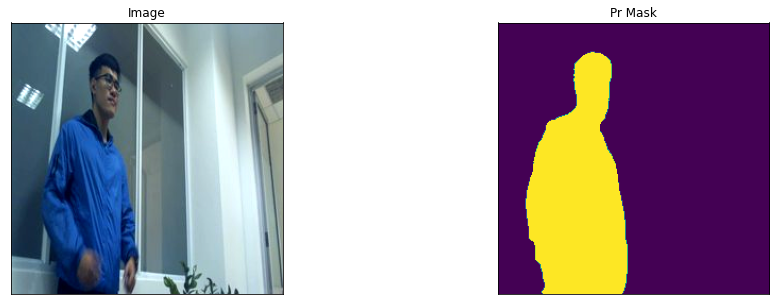

In [ ]:
image, gt_mask = test_dataset[76]
pr_mask = pred_mask[76]
visualize(
    image=denormalize(image.squeeze()),
    pr_mask=pr_mask.squeeze())

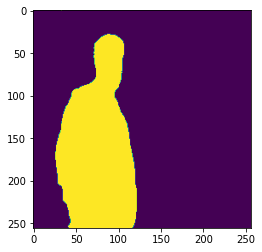

In [ ]:
image, gt_mask = test_dataset[76]
image = np.expand_dims(image, axis=0)
pr_mask = model.predict(image)
pr_mask = np.reshape(pr_mask, (256,256))
pr_mask = np.where(pr_mask < 0.5, 1, 0)
plt.imshow(pr_mask)
# pred_mask

In [ ]:
import pandas as pd
df = pd.DataFrame({'pred_mask': pred_mask})
df.head(5)

,pred_mask
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [ ]:
from google.colab import files
df.to_csv('output.csv', encoding = 'utf-8-sig') 

In [ ]:
import numpy as np 
import pandas as pd

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

 
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# Time Test
masks = pd.read_csv('/content/output.csv')
num_masks = masks.shape[0]
mask_rle_lst = []


for r in df.pred_mask:
    # mask = rle_decode(r.Mask,(256,256)) 
    mask_rle = rle_encode(r)
    mask_rle_lst.append(mask_rle)

In [ ]:
results = pd.DataFrame({'Type': [0 for i in range(1255)], 
                        'image': [str(i)+'.png' for i in range(1255)], 
                        'masl_rle': [mask_rle_lst[i] for i in range(1255)]}, index=None)
results.head(5)

,Type,image,masl_rle
0,0,0.png,20077 3 20332 5 20587 6 20843 6 21099 6 21355 ...
1,0,1.png,371 3 627 3 883 5 1137 8 1388 14 1642 17 1897 ...
2,0,2.png,15251 2 15505 6 15760 9 16015 11 16270 13 1652...
3,0,3.png,21117 4 21370 8 21625 11 21880 13 22135 14 223...
4,0,4.png,100 8 355 9 611 8 867 10 1122 15 1377 17 1632 ...


In [ ]:
results.to_csv('results.csv', encoding = 'utf-8-sig', index=False) 